In [1]:
import time
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim

import DRLPDE_functions.EvaluateWalkers
 
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 300


In [2]:
dt = 1e-2
num_ghost = 512
tol=1e-6

In [3]:
global L_height, v0

############## Save model and/or Load model ##############

# Physical Dimension
x_dim = 2
output_dim = 2

is_unsteady = False
input_dim = x_dim + is_unsteady

L_height = 0.5
v0 = 1.513787

# Is there a true solution
exists_analytic_sol = False
# If there is a true solution, provide contour levels
plot_levels = np.linspace(-1,1,100)

def true_solution(X):
    pass

################# PDE Coefficients ########################

# PDE type:
pde_type = 'NavierStokes'

# Diffusion coefficient
mu = 1

# Forcing term
def forcing(X):
    f = torch.zeros( (X.size(0), output_dim), device=X.device)
    return f

################# Boundary and Initial Conditions ###########
# Use pytorch expressions to make boundary and initial conditions 
#
# To make different boundary conditions for each boundary
#     ensure the correct bdry_con is called when defining the boundaries

def bdry_con(X):
    u = torch.zeros( (X.size(0), output_dim), device=X.device)
    return u

def inlet_con(X):
    u = torch.zeros_like(X, device=X.device)
    
    u[:,0] = v0*torch.mul((L_height - X[:,1]),(L_height + X[:,1]))/(L_height**2)

    return u

#################  Make the domain  #######################
#     First define a bounding box containing your domain
#         Syntax: [ x interval, y interval, z interval ]
#         Points will be sampled through rejection sampling
#
#     Define each boundary
#         lines: [ 'line', point, normal, endpoints, bdry_condition ]
#         disk:  [ 'disk', centre, radius, endpoints, bdry_condition]
#         
#     Intersections of boundaries must be input manually
#         These should be ordered as points will be sampled from first to second
#         only 2 intersection points allowed
#         
#     Boundary condition is given by a function using pytorch expressions


boundingbox = [ [0, 5*L_height], [-L_height,L_height] ]

wall_left = {'type':'line',
             'point': [0, -L_height],
             'normal': [1,0],
             'endpoints': [ [0, -L_height], [0, L_height] ],
             'boundary_condition': inlet_con }

wall_top = { 'type':'line',
             'point': [0, L_height],
             'normal':  [0,-1],
             'endpoints': [ [0, L_height], [5*L_height, L_height] ],
             'boundary_condition': bdry_con }

wall_bot = {'type':'line',
             'point': [0,-L_height],
             'normal': [0, 1],
             'endpoints': [ [0, -L_height], [5*L_height, -L_height] ],
             'boundary_condition': bdry_con }

list_of_dirichlet_boundaries = [wall_left, wall_top, wall_bot ]
list_of_periodic_boundaries =[]

In [4]:
class FeedForwardNN(nn.Module):
    
    ### Feed forward neural network
    
    def __init__(self, depth, width, x_dim, is_unsteady, output_dim, **nn_param):
        super(FeedForwardNN, self).__init__()
        
        self.input_dim = x_dim + is_unsteady
        
        modules = []
        modules.append(nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(nn.Linear(depth, depth))
            modules.append(nn.ELU())
        modules.append(nn.Linear(depth, output_dim))
        
        self.sequential_model = nn.Sequential(*modules)
        
    def forward(self, x):
        a = self.sequential_model(x)
        
        return a

class PotentialNN(nn.Module):
    
    def __init__(self, depth, width, x_dim, is_unsteady, output_dim, **nn_param):
        super(PotentialNN, self).__init__()
        
        self.input_dim = x_dim + is_unsteady
        
        modules = []
        modules.append(nn.Linear(self.input_dim, depth))
        for i in range(width - 1):
            modules.append(nn.Linear(depth, depth))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(depth, 1))
        
        self.sequential_model = nn.Sequential(*modules)
        
    def forward(self, x):
        p = self.sequential_model(x)
        
        a = torch.autograd.grad(p, x, grad_outputs = torch.ones_like(p), create_graph = True, 
                                        retain_graph = True, only_inputs = True)[0]

        return a

    def evaluate_potential(self,x):
        p = self.sequential_model(x)

        return p

In [5]:
class Domain:
    ### This class defines the domain using the parameters provided
    ### It sets up the boundingbox and each boundary

    def __init__(self, is_unsteady, boundingbox, 
                list_of_dirichlet_boundaries,
                list_of_periodic_boundaries):
        
        self.boundingbox = boundingbox
        self.is_unsteady = is_unsteady

        self.num_of_boundaries = len(list_of_dirichlet_boundaries)
        
        # Unpack dirichlet boundary descriptions
        self.boundaries = []
        for specs in list_of_dirichlet_boundaries:
            ### 2D boundaries
            if specs['type'] == 'line':
                self.boundaries.append( bdry_line( point = specs['point'], 
                                                   normal = specs['normal'],
                                                   endpoints = specs['endpoints'],
                                                   boundary_condition = specs['boundary_condition'] ))
        # Unpack any periodic boundaries
        self.periodic_boundaries = []
        for specs in list_of_periodic_boundaries:
            self.periodic_boundaries.append( bdry_periodic( variable = specs['variable'],
                                                            base = specs['base'],
                                                            top = specs['top']  ))
class bdry_line:
    ### Class structure for a line boundary
    ###       normal vector points inside
    
    def __init__(self, point, normal, endpoints, boundary_condition):
        self.point = torch.tensor(  point )
        self.normal = torch.tensor( normal )
        self.constant = -sum( self.normal*self.point )
        
        self.bdry_cond = boundary_condition
        
        self.endpoints = torch.tensor(endpoints)
        
    def make_bdry_pts(self, num_bdry, boundingbox, is_unsteady, other_bdrys):
        
        if is_unsteady:
            Xbdry = torch.cat( ( (self.endpoints[1] - self.endpoints[0] )*torch.rand((num_bdry,1)) + self.endpoints[0],
                                 (boundingbox[-1][1] - boundingbox[-1][0])*torch.rand((num_bdry,1)) + boundingbox[-1][0]), dim=1)
        else:    
            Xbdry = ( self.endpoints[1] - self.endpoints[0] )*torch.rand((num_bdry,1)) + self.endpoints[0]
 
        ### Check if outside other bdrys
        ### and remake bdry points
        outside = torch.zeros(Xbdry.size(0), dtype=torch.bool)

        for bdry in other_bdrys:
            outside += bdry.dist_to_bdry(Xbdry) < 0
        
        if any(outside):
            Xbdry[outside,:] = self.make_bdry_pts(torch.sum(outside), boundingbox, is_unsteady, other_bdrys)

        return Xbdry
    
    def dist_to_bdry(self, X):
        ### Signed distance to boundary
        ### positive = inside domain
        ### negative = outside domain
        distance = torch.sum( self.normal.to(X.device)*X[:,:2], dim=1) + self.constant
        
        return distance
    
    def plot_bdry(self, num_bdry):
        Xplot = ( self.endpoints[1] - self.endpoints[0] )*torch.linspace(0, 1, num_bdry)[:,None] + self.endpoints[0]
        
        return Xplot

def generate_interior_points( boundingbox, boundaries):
    ### Generate points inside the domain
    
    x1 = (boundingbox[0][1] - boundingbox[0][0])*torch.linspace( dt, 1-dt, numpts_x ) + boundingbox[0][0]
    x2 = (boundingbox[1][1] - boundingbox[1][0])*torch.linspace( dt, 1-dt, numpts_y ) + boundingbox[1][0]
    X = torch.cartesian_prod( x1, x2)

    outside = torch.zeros( X.size(0), dtype=torch.bool)
    for bdry in boundaries:
        outside += bdry.dist_to_bdry(X) < 0
    
    if any(outside):
        X[outside,:] = generate_interior_points(torch.sum(outside), boundingbox, boundaries)
        
    return X

class Walker_Data(torch.utils.data.Dataset):
    
    def __init__(self, boundingbox, boundaries):
        
        ### Define bdry exit condition
        def find_bdry_exit(Xold, Xnew, bdry, tol):
            ### Bisection algorithm to find the exit between Xnew and Xold up to a tolerance 
            
            Xmid = (Xnew + Xold)/2
            
            dist = bdry.dist_to_bdry(Xmid)
            
            # above tolerance = inside
            # below tolerance = outside
            above_tol = dist > tol
            below_tol = dist < -tol
            
            if torch.sum(above_tol + below_tol) > 0:
                Xnew[below_tol,:] = Xmid[below_tol,:]
                Xold[above_tol,:] = Xmid[above_tol,:]
                
                Xmid[above_tol + below_tol,:] = find_bdry_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], bdry, tol)

            return Xmid

        ### Generate points -- requires grad
        self.Xold = generate_interior_points(boundingbox, boundaries).requires_grad_(True)

        ### Move Walkers
        Uold = model_velocity(self.Xold)
        self.Xold.requires_grad_(False)

        Zt = np.sqrt(dt)*torch.randn((self.num_pts*num_ghost, x_dim))

        self.Xnew = self.Xold.detach().repeat(num_ghost,1) - dt*Uold.detach().repeat(num_ghost,1) + np.sqrt(2*mu)*Zt

        for bdry in Domain.boundaries:
            outside_bdry = bdry.dist_to_bdry(self.Xnew) < 0
            
            self.Xnew[outside_bdry,:] = find_bdry_exit(self.Xold.detach().repeat(num_ghost,1)[outside_bdry,:], self.Xnew[outside_bdry,:], bdry, tol)
        
        self.Xnew.requires_grad=True
        Unew = model_velocity(self.Xnew).reshape(num_ghost, self.num_pts, output_dim).mean(0)
        
        ### Should be negative
        self.target = (Unew - Uold).detach()/dt

        self.Xnew = self.Xnew.detach().reshape(num_ghost,self.num_pts,x_dim)

    def __len__(self):
        ### How many data points are there?
        return numpts
    
    def __getitem__(self, index):
        ### Gets one sample of data
        ### 
        return self.Xold[index,:], self.Xnew[:,index,:], self.target[index,:]

### Functions
def eval_gradient(X, model):
    X.requires_grad = True
    a = model(X)

    grad_model = torch.autograd.grad(a, X, grad_outputs = torch.ones_like(a), create_graph = True, 
                                       retain_graph = True, only_inputs = True)[0]

    return grad_model

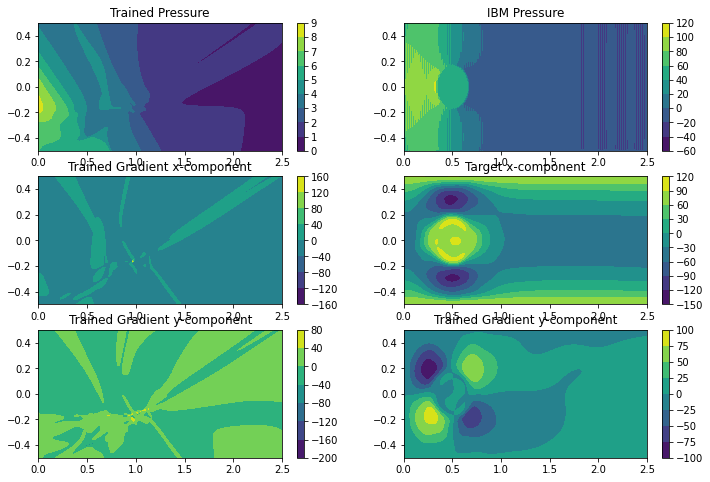

In [6]:
Domain = Domain(is_unsteady, boundingbox, list_of_dirichlet_boundaries, list_of_periodic_boundaries)

model_velocity = torch.load("savedmodels/JCPexample6.pt").to('cpu').eval()
model_pressure = torch.load("savedmodels/pressure_test.pt").to('cpu').eval()

### Import Immersed Boundary Method

Nx = 256 # Number of points along x-axis - Does not count end point
Ny = 160 # Number of points along y-axis - Does not count end point
N_channel = 128
pressure_vtk = 'Steady_FPD_p_1-513787'
IBM_P = np.transpose( np.loadtxt('tools/vtk_files/' + pressure_vtk + '.vtk') )
IBM_P = IBM_P[:, 16:N_channel + 16 + 1]
IBM_P = np.concatenate( (IBM_P, IBM_P[0,None,:]), axis=0)

######################## Plotting and Error Parameters ########################
numpts_plot_x = 257
numpts_plot_y =  129

xplot = torch.cartesian_prod(torch.linspace(0,5*L_height,numpts_plot_x),
                           torch.linspace(-L_height,L_height,numpts_plot_y)).requires_grad_(True)

#integral_factor = ((L_right - L_left)/(numpts_x-1))*((2*L_height)/(numpts_y-1))

### Model to cpu

model_pressure.to('cpu')

Trained_Gradient = model_pressure(xplot)
Trained_Pressure = model_pressure.evaluate_potential(xplot)
#Trained_Gradient = eval_gradient(xplot, model_pressure)

### Generate points -- requires grad

### Define bdry exit condition
def find_bdry_exit(Xold, Xnew, bdry, tol):
    ### Bisection algorithm to find the exit between Xnew and Xold up to a tolerance 
    
    Xmid = (Xnew + Xold)/2
    
    dist = bdry.dist_to_bdry(Xmid)
    
    # above tolerance = inside
    # below tolerance = outside
    above_tol = dist > tol
    below_tol = dist < -tol
    
    if torch.sum(above_tol + below_tol) > 0:
        Xnew[below_tol,:] = Xmid[below_tol,:]
        Xold[above_tol,:] = Xmid[above_tol,:]
        
        Xmid[above_tol + below_tol,:] = find_bdry_exit(Xold[above_tol + below_tol,:], Xnew[above_tol + below_tol,:], bdry, tol)

    return Xmid

### Move Walkers
Uold = model_velocity(xplot)

Zt = np.sqrt(dt)*torch.randn((numpts_plot_x*numpts_plot_y*num_ghost, x_dim))

Xnew = xplot.repeat(num_ghost,1) - dt*Uold.repeat(num_ghost,1) + np.sqrt(2*mu)*Zt

for bdry in Domain.boundaries:
    outside_bdry = bdry.dist_to_bdry(Xnew) < 0
    
    Xnew[outside_bdry,:] = find_bdry_exit(xplot.repeat(num_ghost,1)[outside_bdry,:], Xnew[outside_bdry,:], bdry, tol)

Unew = model_velocity(Xnew).reshape(num_ghost*numpts_plot_x*numpts_plot_y, output_dim).mean(0)

target = (Unew - Uold).detach()/dt

### Plotting

plt.close('all')
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[12, 8])

contour0 = ax[0,0].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                          xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                        Trained_Pressure.reshape(numpts_plot_x, numpts_plot_y).detach().numpy(), cmap=plt.cm.viridis)
ax[0,0].set_title(r'Trained Pressure')
plt.colorbar(contour0, ax=ax[0,0])

contour1 = ax[0,1].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            IBM_P, cmap=plt.cm.viridis)
ax[0,1].set_title(r'IBM Pressure')
plt.colorbar(contour1, ax=ax[0,1])

contour2 = ax[1,0].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            Trained_Gradient[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().numpy(), cmap=plt.cm.viridis)
ax[1,0].set_title(r'Trained Gradient x-component')
plt.colorbar(contour2, ax=ax[1,0])

contour3 = ax[1,1].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            target[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().numpy(), cmap=plt.cm.viridis)
ax[1,1].set_title(r'Target x-component')
plt.colorbar(contour3, ax=ax[1,1])

contour4 = ax[2,0].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            Trained_Gradient[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().numpy(), cmap=plt.cm.viridis)
ax[2,0].set_title(r'Trained Gradient y-component')
plt.colorbar(contour4, ax=ax[2,0])

contour5 = ax[2,1].contourf(xplot[:,0].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            xplot[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().cpu().numpy(),
                            target[:,1].reshape(numpts_plot_x, numpts_plot_y).detach().numpy(), cmap=plt.cm.viridis)
ax[2,1].set_title(r'Trained Gradient y-component')
plt.colorbar(contour5, ax=ax[2,1])